In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
pd.set_option('display.max_columns', None)
csv_path = 'StudentPerformanceFactors.csv'
df = pd.read_csv(csv_path)
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [13]:
df.info()

# Verificar se há valores ausentes
print("\nValores nulos por coluna:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [14]:
# Preencher valores ausentes com a moda (valor mais comum da coluna)
cols_com_faltantes = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

for col in cols_com_faltantes:
    moda = df[col].mode()[0]
    df[col].fillna(moda, inplace=True)

# Verificação final
print(df.isnull().sum().sum(), "valores nulos restantes")


0 valores nulos restantes


/tmp/ipykernel_10004/2221442634.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(moda, inplace=True)


In [15]:
bins = [0, 59, 79, 100]
labels = ['Low', 'Medium', 'High']

df['Performance_Level'] = pd.cut(df['Exam_Score'], bins=bins, labels=labels, include_lowest=True)
df['Performance_Level'].value_counts()

Performance_Level
Medium    6491
Low         68
High        47
Name: count, dtype: int64

In [18]:
df['Passed'] = (df['Exam_Score'] >= 70).astype(int)
df['Passed'].value_counts()

Passed
0    4982
1    1625
Name: count, dtype: int64

In [24]:
# Separar features (X) e target (y)
x = df.drop(columns=['Exam_Score', 'Performance_Level', 'Passed'])
y = df['Passed']

# Identificar colunas numéricas e categóricas
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = x.select_dtypes(include=['object']).columns.tolist()

print("Colunas numéricas:", numeric_features)
print("Colunas categóricas:", categorical_features)


Colunas numéricas: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
Colunas categóricas: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Transformação numérica: preencher missing (se houver) e escalar
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # no seu dataset numérico já não tem nulos, mas é seguro
    ('scaler', StandardScaler())
])

# Transformação categórica: preencher missing e aplicar One-Hot Encoding
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # já tratamos, mas reforço
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Colocar tudo em ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       997
           1       0.95      0.60      0.74       325

    accuracy                           0.89      1322
   macro avg       0.92      0.79      0.83      1322
weighted avg       0.90      0.89      0.89      1322



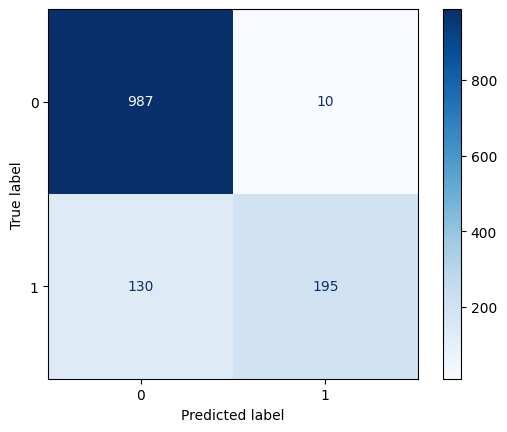

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Criar pipeline completo
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Treinar modelo
clf.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar modelo
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')


In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


In [29]:
# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [30]:
# Transformação numérica
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformação categórica
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


              precision    recall  f1-score   support

           0       0.91      0.98      0.94       997
           1       0.91      0.71      0.79       325

    accuracy                           0.91      1322
   macro avg       0.91      0.84      0.87      1322
weighted avg       0.91      0.91      0.91      1322



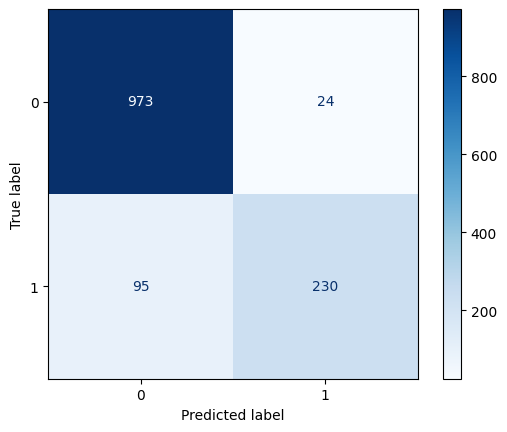

In [31]:
# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

# Treinar RandomForest no dataset balanceado
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

# Prever no conjunto de teste original
X_test_transformed = preprocessor.transform(X_test)
y_pred = clf.predict(X_test_transformed)

# Avaliar modelo
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
